In [1]:
# get_ipython().magic('matplotlib notebook')
get_ipython().magic('matplotlib inline')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy     as np
import time      as clock

/home/a/a270042/tripyview


In [2]:
# from dask.distributed import Client
# from dask.diagnostics import ProgressBar
# import dask

# n_workers=36
# tot_mem  = 100 # GB
# print(' --> memory_limit: {:3.3f} GB'.format(tot_mem/(n_workers+1)))
# dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
# client = Client(n_workers=n_workers, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(tot_mem/n_workers))
# client

In [3]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
# mesh_path = '/work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
mesh_path = '/work/ab0995/a270062/dart/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= None #5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'z-xmoc'

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_jayne_bin_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_stormtide_bin_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/')
input_paths.append('/work/ab0995/a270062/xiosc/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
# input_names.append('TKE')
input_names.append('Tido dart')

vname     = 'amoc'
year      = [1979,2019]
# year      = [1950,1950]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/' # None
ref_name  = None #'TKE, ck=0.1' # None
ref_year  = None #[1979,2019]
ref_mon, ref_day, ref_record = None, None, None
ref_cstr, ref_cnum = 'blue2red', 20
ref_cref, ref_crange, ref_cmin, ref_cmax, ref_cfac, ref_climit = None, None, None, None, None, None
ref_chist, ref_ctresh = True, 0.995
ref_rescale = None

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 20
cref      = 0
crange, cmin, cmax, cfac, climit = None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncolumn   = 2 
do_rescale= None
which_dpi = 300
do_contour= True
do_reffig = True
figfac    = [8, 3.5] #[7, 3.5]
do_wbolus = True


In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (which_cycl is not None) and (which_cycl is not "None"): 
    for ii,ipath in enumerate(input_paths):
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])
        
    if (ref_path is not None) and (ref_path is not "None"): 
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)        
        
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path is not None) and (ref_path is not "None"): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record    
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)    
    ref_cinfo['cref']=0.0 
else:
    do_reffig=False    

 > found *.pckl file: /work/ab0995/a270062/dart
 > load  *.pckl file: tripyview_fesom2_dart_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /work/ab0995/a270062/dart
 > id              = dart
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 3160340
 > #elem           = 6262485
 > #lvls           = 80
___________________________________________


In [5]:
aux_vname, aux_vnamebv = 'w', 'bolus_w'

#___LOAD FESOM2 REFERENCE DATA________________________________________________________________________
if (ref_path is not None) and (ref_path is not "None"):
    print(ref_path)
    data_ref = tpv.load_data_fesom2(mesh, ref_path, vname=aux_vname, year=ref_year, descript=ref_name , 
                                    do_info=False, do_zarithm=None, do_nan=False, do_compute=False) 
    if do_wbolus: data_ref[aux_vname].data = data_ref[aux_vname].data+tpv.load_data_fesom2(mesh, ref_path, vname=aux_vnamebv, year=ref_year, 
                                            do_info=False, do_zarithm=None, do_nan=False, do_compute=False)[aux_vnamebv].data
        
#___LOAD FESOM2 DATA___________________________________________________________________________________    
data_list = list()
ts = clock.time()
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    data = tpv.load_data_fesom2(mesh, datapath, vname=aux_vname, year=year, descript=descript, 
                                do_info=False, do_zarithm=None, do_nan=False, do_compute=False) 
    if do_wbolus: data[aux_vname].data = data[aux_vname].data+tpv.load_data_fesom2(mesh, datapath, vname=aux_vnamebv, year=year, 
                                        do_info=False, do_zarithm=None, do_nan=False, do_compute=False)[aux_vnamebv].data
    data_list.append(data)
    del(data)

    
#___COMPUTE XMOC_______________________________________________________________________________________
moc_list = list()
if (ref_path is not None) and (ref_path is not "None"):
    moc_ref = tpv.calc_xmoc(mesh, data_ref, dlat=1.0, which_moc=vname, do_info=False)
    del(data_ref)
    if do_reffig: moc_list.append(moc_ref) 

for data in data_list:
    moc = tpv.calc_xmoc(mesh, data, dlat=1.0, which_moc=vname, do_info=False)
    if ref_path is not None: moc_list.append( tpv.do_anomaly(moc, moc_ref) )
    else:                    moc_list.append( moc )
del(data_list, data, moc)        
print(' --> elasped time: {} min.'.format( (clock.time()-ts)/60  ))

/work/ab0995/a270062/xiosc/ Tido dart
 --> elasped time: 0.20968963702519736 min.


--> histo: cmin, cmax =  -4.4515760167897245 15.504887359992814
{'cstr': 'blue2red', 'cnum': 20, 'cref': 0, 'chist': True, 'ctresh': 0.995, 'cmin': -4.45, 'cmax': 15.5, 'cmap': <matplotlib.colors.ListedColormap object at 0x7ffeb5a9d4d0>, 'clevel': array([-4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,
        1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,
        6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5,
       12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5])}


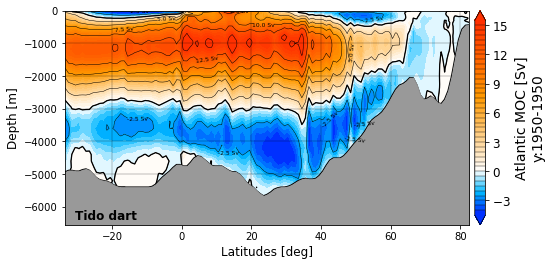

In [6]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = vname
slabel = moc_list[0]['moc'].attrs['str_lsave']
if spath is not None: spath  = os.path.join(spath,'{}_{}_{}.png'.format(which_mode, sname, slabel)) 
ncolumn= np.min([ncolumn,len(moc_list)])        
nrow   = np.ceil(len(moc_list)/ncolumn).astype('int')
if save_fname is not None: spath = save_fname
pos_gap = [0.01, 0.04]

#____________________________________________________________________________________________________
fig, ax, cbar=tpv.plot_xmoc(moc_list, which_moc=vname, cinfo=cinfo, figsize=[ncolumn*figfac[0], nrow*figfac[1]], 
                            n_rc=[nrow, ncolumn], pos_gap=pos_gap, pos_extend=[0.05, 0.05, 0.85, 0.90], 
                            do_reffig=do_reffig, ref_cinfo=ref_cinfo, 
                            do_save=spath, save_dpi=which_dpi, do_contour=do_contour)